NYC Parking Data Cleaning
==========
(Take 2)
------

# 1. Obtain the data

In [5]:
# NYC LION street Lines
! cd data && curl -O "https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyclion_18a.zip" && unzip nyclion_18a.zip && rm nyclion_18a.zip

# NYC Street Parking Signs
! cd data && curl -O "http://a841-dotweb01.nyc.gov/datafeeds/ParkingReg/Parking_Regulation_Shapefile.zip" && unzip Parking_Regulation_Shapefile.zip && rm Parking_Regulation_Shapefile.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21.8M  100 21.8M    0     0  1629k      0  0:00:13  0:00:13 --:--:-- 1926k
Archive:  Parking_Regulation_Shapefile.zip
  inflating: Parking_Regulation_Shapefile/Parking Regulation Metadata.pdf  
 extracting: Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.CPG  
  inflating: Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.dbf  
  inflating: Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.prj  
  inflating: Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.sbn  
  inflating: Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.sbx  
  inflating: Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.shp  
  inflating: Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.shp.xml  
  inflating: Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.shx  


In [127]:
! pip install -U fiona dateutil
! pip install pyqtree
! brew upgrade gdal
! brew install spatialindex

Requirement already up-to-date: fiona in /anaconda3/lib/python3.6/site-packages
Requirement already up-to-date: six in /anaconda3/lib/python3.6/site-packages (from fiona)
Requirement already up-to-date: click-plugins in /anaconda3/lib/python3.6/site-packages (from fiona)
Requirement already up-to-date: cligj in /anaconda3/lib/python3.6/site-packages (from fiona)
Requirement already up-to-date: munch in /anaconda3/lib/python3.6/site-packages (from fiona)
Requirement already up-to-date: click>=3.0 in /anaconda3/lib/python3.6/site-packages (from click-plugins->fiona)
You are using pip version 9.0.2, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Updating Homebrew...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core, caskroom/cask).
No changes to formulae.

Error: gdal 2.2.4 already installed
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
You 

In [1]:
import pandas as pd
import geopandas as gpd
import re
from dateutil.rrule import rrule, WEEKLY
from datetime import datetime

In [27]:
signs = gpd.read_file('data/Parking_Regulation_Shapefile/Parking_Regulation_Shapefile.shp')

In [3]:
aspsigns = signs[signs.SIGNDESC1.str.contains('\(SANITATION BROOM SYMBOL\)')]

In [4]:
aspsigns.SIGNDESC1.value_counts()

NO PARKING (SANITATION BROOM SYMBOL) 11:30AM TO 1PM MON & THURS <---->                                                    3955
NO PARKING (SANITATION BROOM SYMBOL) 11:30AM TO 1PM TUES & FRI <---->                                                     3928
NO PARKING (SANITATION BROOM SYMBOL) TUESDAY FRIDAY 11:30AM-1PM <->                                                       3638
NO PARKING (SANITATION BROOM SYMBOL) MONDAY THURSDAY 11:30AM-1PM <->                                                      3567
NO PARKING (SANITATION BROOM SYMBOL) 9:30-11AM MON & THURS <--->                                                          3011
NO PARKING (SANITATION BROOM SYMBOL) 11:30AM TO 1PM TUES <---->                                                           2978
NO PARKING (SANITATION BROOM SYMBOL) 11AM TO 12:30PM TUES & FRI <---->                                                    2914
NO PARKING (SANITATION BROOM SYMBOL) 11:30AM TO 1PM MON <--->                                                  

In [12]:
aspsigns[aspsigns.SIGNDESC1.str.contains("EXCEPT")].SIGNDESC1.value_counts()

NO PARKING (SANITATION BROOM SYMBOL) 7:30AM-8AM EXCEPT SUNDAY <->                                                     2615
NO PARKING (SANITATION BROOM SYMBOL) 8AM-8:30AM EXCEPT SUNDAY <->                                                     2426
NO PARKING (SANITATION BROOM SYMBOL) 8:30AM-9AM EXCEPT SUNDAY <->                                                     1502
NO PARKING (SANITATION BROOM SYMBOL) 7:30AM-8AM EXCEPT SUNDAY -->                                                      988
NO PARKING (SANITATION BROOM SYMBOL) 8AM-8:30AM EXCEPT SUNDAY -->                                                      929
NO PARKING (SANITATION BROOM SYMBOL) 8:30AM-9AM EXCEPT SUNDAY -->                                                      610
NO PARKING (SANITATION BROOM SYMBOL) 7AM-7:30AM EXCEPT SUNDAY <->                                                      299
NO PARKING (SANITATION BROOM SYMBOL) 8AM-9AM EXCEPT SUNDAY <->                                                         287
NO PARKING (SANI

## What is the data model for a parking restriction?

* Street Segment
* Day(s) of week
* Time of Restriction (on those days)


In [120]:
TIMERE = re.compile('(\d+:?\d*[A|P]?M?|NOON|MIDNIGHT)(?:-| TO | | TO-|)(\d+:?\d*[A|P]?M?|NOON|MIDNIGHT)')
MIDDAY = re.compile('([A|P]M)')
EXCEPTDAYS = re.compile('EXCEPT (MONDAY|TUESDAY|WEDNESDAY|THURSDAY|FRIDAY|SATURDAY|SUNDAY|MON|TUES|WED|THURS|FRI|SAT|SUN)+')
RANGEDAYS = re.compile('(MONDAY|TUESDAY|WEDNESDAY|THURSDAY|FRIDAY|SATURDAY|SUNDAY|MON|TUES|WED|THURS|FRI|SAT|SUN)-(MONDAY|TUESDAY|WEDNESDAY|THURSDAY|FRIDAY|SATURDAY|SUNDAY|MON|TUES|WED|THURS|FRI|SAT|SUN)')
ALLDAYS = re.compile('(MONDAY|TUESDAY|WEDNESDAY|THURSDAY|FRIDAY|SATURDAY|SUNDAY|MON|TUES|WED|THURS|FRI|SAT|SUN)')

In [7]:
TIMERE.findall('NO PARKING (SANITATION BROOM SYMBOL) 10:30AM TO NOON MON & THURS W/SINGLE ARROW')

[('10:30AM', 'NOON')]

In [21]:
smp = aspsigns.sample(1000)

In [22]:


for ix, row in smp.iterrows():

    try:
        timeFrom, timeTo = TIMERE.findall(row['SIGNDESC1'])[0]
    except:
        print(row)
        raise
    if timeFrom == "NOON": timeFrom = "12:00PM"
    if timeFrom == "MIDNIGHT": timeFrom = "12:00AM"
    if timeTo == "NOON": timeTo = "12:00PM"
    if timeTo == "MIDNIGHT": timeTo = "12:00AM"
    if not MIDDAY.search(timeFrom) and MIDDAY.search(timeTo):
        timeFrom += (MIDDAY.findall(timeTo)[0])
        

In [8]:
def timeRules(signdesc):
    try:
        timeFrom, timeTo = TIMERE.findall(signdesc)[0]
    except:
        print(signdesc)
        raise
    if timeFrom == "NOON":
        timeFrom = "12:00PM"
    if timeFrom == "MIDNIGHT":
        timeFrom = "12:00AM"
    if timeTo == "NOON":
        timeTo = "12:00PM"
    if timeTo == "MIDNIGHT":
        timeTo = "12:00AM"
    if not MIDDAY.search(timeFrom) and MIDDAY.search(timeTo):
        timeFrom += (MIDDAY.findall(timeTo)[0])
    
    return timeFrom, timeTo

In [112]:
NORMALIZEDAYS = {
    'SUNDAY': 'SUNDAY',
    'SUN': 'SUNDAY',
    'MONDAY': 'MONDAY',
    'MON': 'MONDAY',
    'TUESDAY': 'TUESDAY',
    'TUE': 'TUESDAY',
    'TUES': 'TUESDAY',
    'WEDNESDAY': 'WEDNESDAY',
    'WED': 'WEDNESDAY',
    'WEDS': 'WEDNESDAY',
    'THURSDAY': 'THURSDAY',
    'THU': 'THURSDAY',
    'THUR': 'THURSDAY',
    'THURS': 'THURSDAY',
    'FRIDAY': 'FRIDAY',
    'FRI': 'FRIDAY',
    'SATURDAY': 'SATURDAY',
    'SAT': 'SATURDAY'
}
def dayRules(signdesc):
    exceptday = EXCEPTDAYS.findall(signdesc)
    rangeday = RANGEDAYS.findall(signdesc)
    alldays = ALLDAYS.findall(signdesc)

    dayslist = ['SUNDAY', 'MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY']
    if exceptday:
        dayslist = ['SUNDAY', 'MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY']
        
        for d in exceptday:
            day = NORMALIZEDAYS[d]
            dayslist.remove(day)
        return dayslist
    elif rangeday:
        #print(rangeday)
        fromDay, toDay = rangeday[0]
        fromIx = dayslist.index(fromDay)
        toIx = dayslist.index(toDay)
        #print(fromIx,toIx)
        return dayslist[fromIx:toIx+1]
    else:
        return alldays
        
        
    
        

In [143]:
for i in vc.index:
    days = dayRules(i)
    try:
        fromTime, toTime = timeRules(i)
    except:
        print(i)
        pass


NO PARKING (SANITATION BROOM SYMBOL) <->
NO PARKING (SANITATION BROOM SYMBOL) <->


# Side Quest: Lets do topic modeling on these sign texts!

Lets look at the unique text of each sign 

In [158]:
count_signs = signs.groupby(['SG_MUTCD_C', 'SIGNDESC1']).size().reset_index(name="Count").sort_values(by="Count", ascending=False)

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
documents = list(count_signs['SIGNDESC1'])

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 50

# Run NMF
# nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 5
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
available description www logo visit
Topic 1:
taxi stand limit symbol hour
Topic 2:
driveway clear broom symbol sanitation
Topic 3:
tunnel bridge tbta august crosswalk
Topic 4:
large lottery stand panel permit
Topic 5:
star symbol avo dept nyc
Topic 6:
arrow sign symbol clock right
Topic 7:
truck symbol loading 6pm friday
Topic 8:
curve president chevron studios hazard
Topic 9:
muni meter pay vehicle marshals
Topic 10:
7pm parking hour 9am metered
Topic 11:
hour 7pm parking 30am metered
Topic 12:
market farmers 30 nov sun
Topic 13:
parking symbol sanitation broom 30am
Topic 14:
information dot parking emergency telecommunications
Topic 15:
tour park layover slippery saturday
Topic 16:
7pm standing monday friday 10am
Topic 17:
diamond red delineator pictorial inch
Topic 18:
mon fri parking standing 8am
Topic 19:
broom 30am symbol parking sanitation
Topic 20:
11am 30pm 12 symbol crossing
Topic 21:
office general mayor justice medical
Topic 22:
city day times bus xyy
Topic 23:
co

# Start matching sign positions to street segments

Steps:
1. Determine the logic for matching a side to each street
1. For each Sign: match sign to closest street segment (and save it to a list on the correct sign)
2. For each street segment: apply the set of street signs (we have logic for) to determine the rules that apply to that street segment

In [198]:
# Convert LION Geodatabase to a GeoJSON file because Geopandas has FEELINGS! about importing geodatabase layers
! ogr2ogr -f "GeoJSON" data/lion/lion.geojson data/lion/lion.gdb lion -s_srs EPSG:2263 -t_srs EPSG:4326

In [2]:
streets = gpd.read_file('data/lion/lion.geojson')

Start your script by importing the quad tree.

from pyqtree import Index
Setup the spatial index, giving it a bounding box area to keep track of. The bounding box being in a four-tuple: (xmin, ymin, xmax, ymax).

spindex = Index(bbox=(0, 0, 100, 100))
Populate the index with items that you want to be retrieved at a later point, along with each item's geographic bbox.

# this example assumes you have a list of items with bbox attribute
for item in items:
    spindex.insert(item, item.bbox)
Then when you have a region of interest and you wish to retrieve items from that region, just use the index's intersect method. This quickly gives you a list of the stored items whose bboxes intersects your region of interests.

overlapbbox = (51, 51, 86, 86)
matches = spindex.intersect(overlapbbox)

In [17]:
! pip install -U rtree

Requirement already up-to-date: rtree in /anaconda3/lib/python3.6/site-packages
Requirement already up-to-date: setuptools in /anaconda3/lib/python3.6/site-packages (from rtree)
You are using pip version 9.0.2, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
import rtree

In [24]:

spindex = rtree.index.Index()

In [25]:
%%time
a = 0
for ix, row in streets.iterrows():
    spindex.insert(ix, row[streets._geometry_column_name].bounds)
    a +=1
print(a)

224762
CPU times: user 47.9 s, sys: 792 ms, total: 48.7 s
Wall time: 48.7 s


## Now that you've built a spatial index, query against each point


In [87]:
for ix, row in signs.iterrows():
    break

In [88]:
ptx = srow[signs._geometry_column_name].centroid.coords.xy[0][0]
pty = srow[signs._geometry_column_name].centroid.coords.xy[1][0]

In [60]:
l = list(spindex.nearest((ptx, pty),num_results=10))
tencloseststreets = streets.iloc[l]

In [69]:
%%time
sample = signs.sample(1000)


CPU times: user 13.4 ms, sys: 1.44 ms, total: 14.9 ms
Wall time: 13.2 ms


In [103]:
# Need to go back and check if what you're measuring is the closest listance to any particular line in the set OR the closest distance to any of the lines
def min_distance(point, lines):
    l = list(spindex.nearest(point,num_results=20))
    tencloseststreets = streets.iloc[l]
    return tencloseststreets #.distance(point).min()

# sample['min_dist_to_lines'] = sample.geometry.apply(lambda x: min_distance(x, streets))

In [107]:
tc = min_distance((ptx,pty), streets)
tc['dist'] = tc.distance(geom.Point(ptx,pty))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [111]:
tc.sort_values(by='dist', ascending=True).iloc[0]

Street                                                     JEROME AVENUE
SAFStreetName                                                           
FeatureTyp                                                             0
SegmentTyp                                                             U
IncExFlag                                                               
RB_Layer                                                               B
NonPed                                                                  
TrafDir                                                                T
TrafSrc                                                              DOT
SpecAddr                                                                
FaceCode                                                            4100
SeqNum                                                             00520
StreetCode                                                        242820
SAFStreetCode                                      

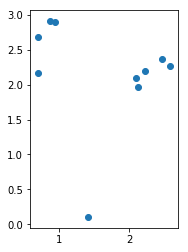

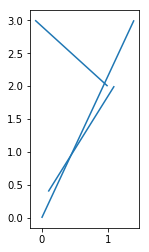

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import shapely.geometry as geom
import numpy as np
import pandas as pd
import geopandas as gpd

lines = gpd.GeoSeries(
    [geom.LineString(((1.4, 3), (0, 0))),
        geom.LineString(((1.1, 2.), (0.1, 0.4))),
        geom.LineString(((-0.1, 3.), (1, 2.)))])

# 10 points
n  = 10
points = gpd.GeoSeries([geom.Point(x, y) for x, y in np.random.uniform(0, 3, (n, 2))])

# Put the points in a dataframe, with some other random column
df_points = gpd.GeoDataFrame(np.array([points, np.random.randn(n)]).T)
df_points.columns = ['Geometry', 'Property1']

points.plot()
lines.plot()

In [91]:
min_dist = np.empty(n)
for i, point in enumerate(points):
    min_dist[i] = np.min([point.distance(line) for line in lines])
df_points['min_dist_to_lines'] = min_dist
df_points

,Geometry,Property1,min_dist_to_lines
0,POINT (2.587525569067006 2.265489672246271),-1.28976,1.386729
1,POINT (0.6852267045629781 2.170226224879901),-0.596716,0.085782
2,POINT (1.402836536106647 0.1035915921385242),-0.212961,1.227419
3,POINT (0.9295067648276186 2.898270813753055),-0.232403,0.383333
4,POINT (0.8584204348276058 2.909473874783404),0.387979,0.452488
5,POINT (2.463409320740991 2.370318610184958),0.172741,1.229927
6,POINT (2.10045590699968 2.101121492239253),1.50484,1.005553
7,POINT (0.6913879848931953 2.682622076014337),0.534162,0.297505
8,POINT (2.124335667810127 1.963941960945636),-1.06457,1.024970
9,POINT (2.232579076628708 2.195068843198911),-1.0892,1.094863


In [116]:
streets.Join_ID.value_counts()

4052901000000      2277
4925502000000      1690
3056501000000      1344
3955502000000       982
4193401000000       805
1108701000000       801
5925502000000       786
4000705010000       729
2880502000000       724
2194201000000       682
1000105010000       578
1992502000000       561
3250601000000       512
5000905000000       480
2730201000000       475
3000505010000       452
4999904000000       413
5611001020000       390
2000305010000       364
4170901000000       352
1368501000000       337
4254601000000       335
1043013020000       327
4203015010000       322
4240844010000       320
2114801000000       306
5206101000000       300
1003010020000       294
1386501000000       293
2108035010000       292
                   ... 
31156511000000X       1
31176525000000X       1
11374016000000X       1
52396314000000X       1
11674008000000X       1
11153501000000N       1
34023505000000X       1
31218001000000N       1
32333848000000X       1
11375016000000X       1
11674012000000X 